In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 120

## Generate Some Data

Create an artificial climate signal at mothly resolution, containing different periodic signals.

Text(0,0.5,'Synthetic Signal')

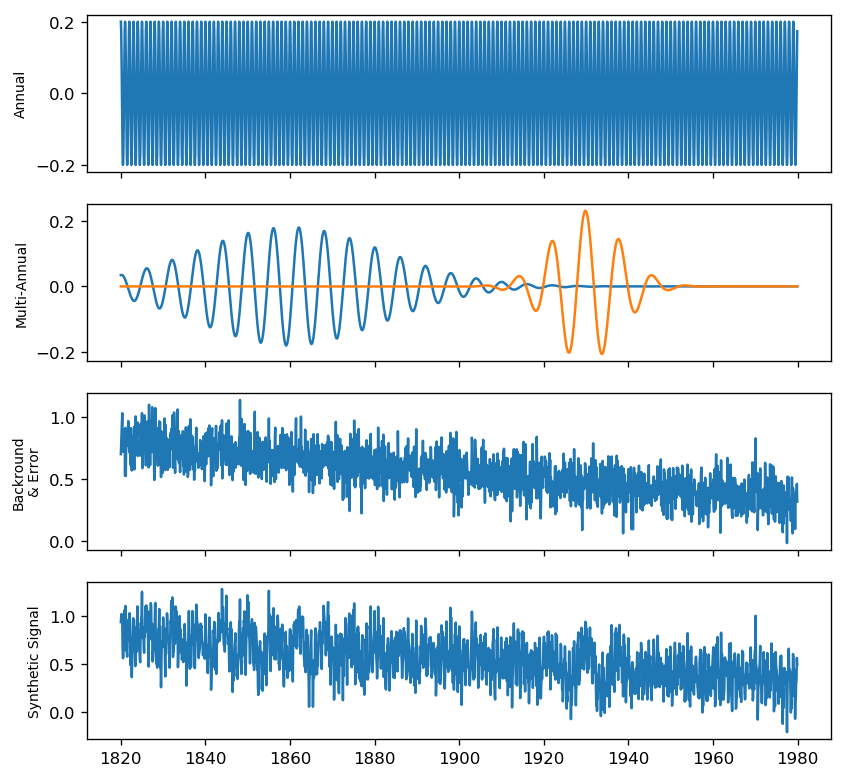

In [3]:
x = np.arange(1820, 1980, 1/12)

# cyclic variability
annual = np.sin((x + 3/12) * 2 * np.pi)  # annual
c1 = np.sin((x - 7/12) * 2 * np.pi / 6)  # 6-year
c2 = np.sin((x + 2/12) * 2 * np.pi / 8)  # 8-year

# appearance and disappearance of multi-year cycles
c1_onoff = stats.norm.pdf(x, 1860, 22)
c2_onoff = stats.norm.pdf(x, 1930, 8)
# normalise the on/off signals
c1_onoff /= c1_onoff.max()
c2_onoff /= c2_onoff.max()

# add noise
err = np.random.normal(0, 0.12, x.size)

# background
bkg = 0.8 + -3e-3 * (x - 1820)

y = (
     annual * 0.2 +  # annual signal
     c1 * 0.18 * c1_onoff +  # 6-year cycle
     c2 * 0.23 * c2_onoff +   # 7-year cycle
     err +  # error
     bkg  # linear background
    )

fig, axs = plt.subplots(4, 1, figsize=[8, 8], sharex=True)

anx, ccx, errx, cmx = axs

anx.plot(x, annual * 0.2)
ccx.plot(x, c1 * c1_onoff * 0.18)
ccx.plot(x, c2 * c2_onoff * 0.23)
errx.plot(x, err + bkg)
cmx.plot(x, y)

anx.set_ylabel('Annual')
ccx.set_ylabel('Multi-Annual')
errx.set_ylabel('Backround\n& Error')
cmx.set_ylabel('Synthetic Signal')

# Torrence and Compo Wavelet Method

Wavelet analysis allows the identification of periodic signals across the duration of a signal. It's key advantage over 'normal' fourier spectral analysis is that it changes the size of the data window depending on the frequency it's looking for, so that all frequencies are resolved with similar 'power' in the resulting spectrogram. For a better explanation see [Torrence and Compo's website](http://paos.colorado.edu/research/wavelets/).

- [Description of method](http://paos.colorado.edu/research/wavelets/).
- [Python Implementation of Method (PyCWT)](http://pycwt.readthedocs.io/en/latest/)
- Code below modified from [this tutorial](http://pycwt.readthedocs.io/en/latest/tutorial.html)


In [4]:
import pycwt as wavelet
from pycwt.helpers import find

In [5]:
# get data
t = x  # time
dat = y  # data

# replace the above with references to your data to use this code with your data

# some data characteristics
dt = t[1] - t[0]  # delta time (time step - must be the same for all data)
t0 = t[0]  # start time
N = t.size  # length of data

# de-trend and normalise data
p = np.polyfit(t - t0, dat, 1)  # fit polynomial
dat_notrend = dat - np.polyval(p, t - t0)  # subtract polynomial
std = dat_notrend.std()  # calculate Standard deviation
var = std ** 2  # calculate Variance
dat_norm = dat_notrend / std  # divide by standard deviation to normalized dataset

In [6]:
# define wavelet parameters
# try using different wavelets, and see what effect it has on the analysis.
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

In [7]:
# apply wavelet transform
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

In [8]:
# calculate the normalised wavelet and Fourier spectra and associated scales
power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

# rectify power spectrum
power /= scales[:, None]

In [9]:
# calculate wavelet significance
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

In [10]:
# calculate global wavelet spectrum, and determine significance
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

In [11]:
# calculate 2-8 year power spectrum and significance
sel = find((period >= 2) & (period < 8))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

## Plot Results

/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


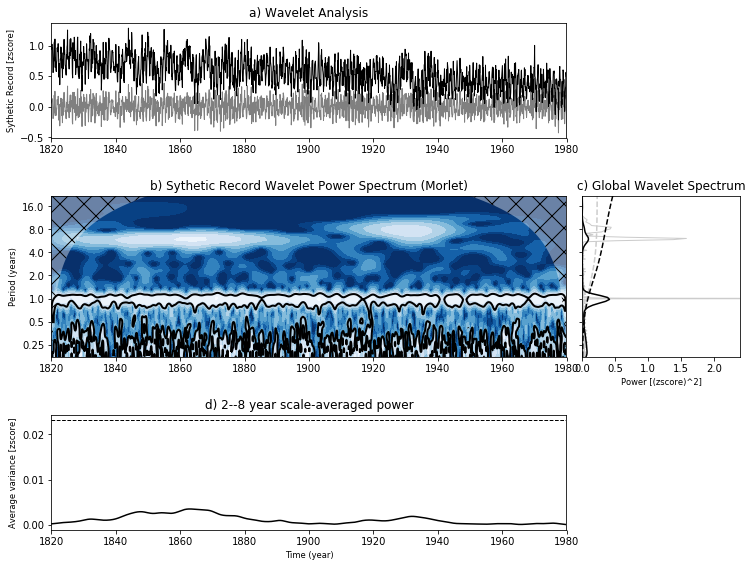

In [12]:
title = 'Wavelet Analysis'
units = 'zscore'
label = 'Sythetic Record'

# Prepare the figure
figprops = dict(figsize=(11, 8), dpi=72)
fig = plt.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = fig.add_axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = fig.add_axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.Blues_r)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'w', alpha=0.4, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                           np.ceil(np.log2(period.max())))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = fig.add_axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, np.log2(period), 'k--', zorder=5)
cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, np.percentile(glbl_power, 90) + var])
cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = fig.add_axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

fig.savefig('wavelets.pdf')

The 6- and 8-year components are clearly visible in the power spectrum, but they are not 'significant'. This is likely because the intensity of the 1-year cycle 'saturates' the analysis. 

We *know* these signals are real, because we generated them, which highlights potential limitations of the analysis. If using this, you'll need to think carefully about what 'significant' means.